### Load and preprocess Data
Tensorflow 2.0에 맞게 다시 Tensorflow를 살펴볼 필요가 있다고 느껴져서 <a href="https://www.tensorflow.org/?hl=ko">Tensorflow 정식 홈페이지</a>에 나와있는 예제부터 전반적인 Tensorflow 사용법을 먼저 익히는 Post가 된다.  
<br>

#### 필요한 Library Import

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import functools

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

### tf.data
<code>tf.data</code>는 Input Data에 대하여 복잡한 전처리 과정이나 Loading하는 과정을 쉽게 할 수 있게 지원하는 것 이다.  
위의 과정으로 Input Data -> tf.data -> Input Tensor로서 편하게 Pipelines를 구출할 수 있는 것 이다.  
tf.data API를 사용하면 많은 양의 데이터를 처리하고 서로 다른 데이터 형식에서 데이터를 읽고 복잡한 변환(전처리 과정)을 수행할 수 있다.  
이러한 dataset을 구축하기 위해서는 다음과 같은 2가지의 조건이 필요하다.
- Dataset은 Memory 혹은 File로서 저장되어있어야 한다.
- Transformation은 tf.data.Dataset object에서 행해 진다. ex) Image의 경우 tf.data.Dataset으로 Object로 만들고 회전변환 혹은 Scaling등 다양한 Transformation을 실시한다.

#### Basic mechanics
기본적으로 <code>tf.data.Dataset</code>으로 만들기 위해서는 Source(원본 데이터)를 <code>tf.data.Dataset.from_tensors()</code>나 <code>tf.data.Dataset.from_tensor_slices()</code> 등으로서 선언하여 Dataset Object로서 변화 시켜야 한다.  

이러한 바뀐 Dataset Object는 다음과 같은 특징을 가지게 된다.  
**Dataset Object 특징**  
- <code>Dataset.map()</code>과 같이 각각의 element에게 Function을 적용할 수 있다.
- <code>Dataset.batch()</code>와 같이 다양한 element에게 Function을 적용할 수 있다.

아래 Code는 간단한 [8, 3, 0, 8, 2, 1]을 Dataset Object로 변환시키고 결과를 확인한다.  
**중요한 점은 TensorSliceDataset같이 Dataset Object는 Numpy의 <code>.take()</code>를 적용하여 가져올 수 있고 EagerTensor는 <code>.numpy()</code>로서 바로 결과를 확인 가능하다.**  
위와 같은 작업을 Eager execution이라 하고 **바로 그래프를 생성하지 않고 계산값을 즉시 알려주는 Tensor로서 Model의 Debugging을 좀 더 쉽게 할 수 있는 기능이라고 한다.(이러한 기능은 나중에 다시 자세히 알아보기로 하자.)**

In [14]:
# Dataset Object 선언
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
print(dataset)

# 각각의 Eager Tensor 확인
for elem in dataset.take(1):
    print(type(elem))
    print(elem.numpy())
    
# Dataset Object는 iter(), next()가 가능하다.
it = next(iter(dataset))
print(it.numpy())

# Dataset Object에 Function 적용
print(dataset.reduce(10, lambda state, value: state + value).numpy())

<TensorSliceDataset shapes: (), types: tf.int32>
<class 'tensorflow.python.framework.ops.EagerTensor'>
8
8
32


#### Datastructure
Dataset은 <a href="https://www.tensorflow.org/api_docs/python/tf/TypeSpec?version=stable">tf.TypeSpec</a>이 표시할 수 있는 모든 구조를 포함할 수 있다.  
<code>Dataset.element_spec</code>: Dataset안의 tf.TypeSpec Object를 확인할 수 있다.  
<code>tf.TypeSpec.value_type</code>: tf.TypeSpec의 구조를 확인할 수 있다.


In [25]:
# Dataset Object => Tensor로 이루워져 있다.
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))

# Dataset Object => Tensor로 이루워져 있다.
dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)))

# Dataset Object => Tensor Array
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

# Dataset Object => Sparse Tensor로 이루워져 있다.
dataset4 = tf.data.Dataset.from_tensors(tf.SparseTensor(indices=[[0, 0], [1, 2]], values=[1, 2], dense_shape=[3, 4]))

# Dataset Object안의 ty.TypeSpec 구조의 자료 Tensor정보 확인
print('Dataset Object 안의 Tensor 정보 확인')
print('dataset1: ',dataset1.element_spec)
print('dataset2: ',dataset2.element_spec)
print('dataset3: ',dataset3.element_spec)
print('dataset4: ',dataset4.element_spec)

print()
print('Tensor 정보 확인')
print('dataset4: ',dataset4.element_spec.value_type)

Dataset Object 안의 Tensor 정보 확인
dataset1:  TensorSpec(shape=(10,), dtype=tf.float32, name=None)
dataset2:  (TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(100,), dtype=tf.int32, name=None))
dataset3:  (TensorSpec(shape=(10,), dtype=tf.float32, name=None), (TensorSpec(shape=(), dtype=tf.float32, name=None), TensorSpec(shape=(100,), dtype=tf.int32, name=None)))
dataset4:  SparseTensorSpec(TensorShape([3, 4]), tf.int32)

Tensor 정보 확인
dataset4:  <class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>


### Load CSV data
Code 참조: <a href="https://www.tensorflow.org/tutorials/load_data/csv?hl=ko">Tensorflow Core Load CSV data</a>
<br>

#### Setup
<code>tf.data.Dataset</code>중 CSV data를 처리하는 방법에 대해서 알아보자.  
먼저 <code>tf.keras.utils.get_file()</code>를 활용하여 URL에서 CSV Format Dataset을 가져오자.  

**tf.keras.utils.get_file()**: Path to the downloaded file  
```code
tf.keras.utils.get_file(
    fname,
    origin,
    untar=False,
    md5_hash=None,
    file_hash=None,
    cache_subdir='datasets',
    hash_algorithm='auto',
    extract=False,
    archive_format='auto',
    cache_dir=None
)
```
<br>
앞으로의 Parameter는 전부 사용하지 않고 자주 사용하는 Parameter를 위주로 알아보자.  

**parameter**
- fname: File이 저장될 path 및 file 이름
- origin: File의 URL
- untar: Bool Type, File압축 해제 여부

참조: <a href="https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file?version=stable">tf.keras.utils.get_file() 설명</a>  

<code>np.set_printoptions(precision=3, suppress=True)</code>: 부동 소수점 숫자, 배열 및 기타 NumPy 객체가 표시되는 방식을 결정
- precision=3: Floating 데이터를 3자리 까지 나타낸다.
- suppress=True: Floating point numbers를 위에서 정의한 precision에 맞게 항상 적용한다.

참조: <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.set_printoptions.html">np.set_printoptions() 설명</a>

In [2]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("eval.csv", TEST_DATA_URL)

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

#### Load data
<code>!head {file_path}</code>: file path의 상위 10줄을 출력  
<a href="https://wjddyd66.github.io/dataanalysis/Pandas/">Pandas</a>를 활용하여서 Data를 Load하거나 처리하여 Numpy형태로 Tensorflow에 전달할 수 있다.  
Data가 커질 경우에는 <code>tf.data.experimental.make_csv_dataset function</code>를 사용하게 된다.  

**tf.data.experimental.make_csv_dataset()**: Read CSV files into a dataset  
```code
tf.data.experimental.make_csv_dataset(
    file_pattern,
    batch_size,
    column_names=None,
    column_defaults=None,
    label_name=None,
    select_columns=None,
    field_delim=',',
    use_quote_delim=True,
    na_value='',
    header=True,
    num_epochs=None,
    shuffle=True,
    shuffle_buffer_size=10000,
    shuffle_seed=None,
    prefetch_buffer_size=dataset_ops.AUTOTUNE,
    num_parallel_reads=1,
    sloppy=False,
    num_rows_for_inference=100,
    compression_type=None,
    ignore_errors=False
)
```
<br>

**parameter**
- file_pattern: CSV records의 file path
- batch_size: Dataset의 Batch
- column_names: CSV records의 columns을 사용자가 원하는 이름으로 지정가능(Factor의 개수 동일해야 함)
- label_name: Label, 즉 Dataset을 Label과 Factor로 분리하여 하나의 Dataset으로서 변형시킬 수 있다.
- num_epochs: 반복할 횟수. 만약 None으로 지정시 무한 반복
- shuffle: Dataset을 섞을지에 대한 option
- na_value: NA/ NaN Value처리를 어떻게 할 것인지 지정
- select_columns: CSV records에서 원하는 columns 선택 가능


참조: <a href="https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset?hl=ko&version=stable">tf.data.experimental.make_csv_dataset() 설명</a> 

In [3]:
!head {train_file_path}

LABEL_COLUMN = 'survived'
LABELS = [0, 1]
def get_dataset(file_path, **kwargs):
    dataset = tf.data.experimental.make_csv_dataset(
        file_path,
        batch_size=5, # Artificially small to make examples easier to show.
        label_name=LABEL_COLUMN,
        na_value="?",
        num_epochs=1,
        ignore_errors=True, 
        **kwargs)
    return dataset

raw_train_data = get_dataset(train_file_path)
raw_test_data = get_dataset(test_file_path)

survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.25,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
1,female,26.0,0,0,7.925,Third,unknown,Southampton,y
1,female,35.0,1,0,53.1,First,C,Southampton,n
0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
0,male,2.0,3,1,21.075,Third,unknown,Southampton,n
1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n
1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n
1,female,4.0,1,1,16.7,Third,G,Southampton,n
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


#### Dataset 확인
위에서 batch_size=5, num_epochs=1로서 정의한 Dataset을 확인하기 위한 Function이다.  
위의 Option으로 인하여 크기가 5인 Dataset이 만들어질 것이고, Label = survived값, columns는 나머지 Factor가 될 것이다.  

**참고사항(<code>numpy.take()</code>)**  
numpy에서 <code>take()</code>는 원하는 Index를 가져오는 Function이다.  
예를 들면 다음과 같다.  
```python
a = np.array([4, 3, 5, 7, 6, 8])
a.take(3) # 7
```
<br>


In [4]:
def show_batch(dataset):
    for batch, label in dataset.take(1):
        print("{:20s}: {}".format('Label',label.numpy()))
        for key, value in batch.items():
            print("{:20s}: {}".format(key,value.numpy()))
            
show_batch(raw_train_data)

Label               : [1 0 0 0 0]
sex                 : [b'male' b'male' b'male' b'female' b'male']
age                 : [28. 24. 16. 57. 34.]
n_siblings_spouses  : [0 0 0 0 0]
parch               : [0 0 0 0 0]
fare                : [26.55   7.496  8.05  10.5    8.05 ]
class               : [b'First' b'Third' b'Third' b'Second' b'Third']
deck                : [b'unknown' b'unknown' b'unknown' b'E' b'unknown']
embark_town         : [b'Southampton' b'Southampton' b'Southampton' b'Southampton'
 b'Southampton']
alone               : [b'y' b'y' b'y' b'y' b'y']


#### Columns 선택
CSV File Format에서 <code>column_names</code>은 모든 Column의 개수와 같으나 사용자가 원하는 대로 Columns의 name을 변화시킬 수 있다.  
CSV File Format에서 <code>select_columns</code>은 원하는 Column를 선택할 수 있다.  

**단, Label로 정의한 Columns는 Dataset의 Factor로서 포함시킬 수 없다.**

In [5]:
# CSV File Columns 변환
print('CSV File Columns 변환')
CSV_COLUMNS = ['survived', '1', '2', '3', '4', '5', '6', '7', '8', '9']
temp_dataset = get_dataset(train_file_path, column_names=CSV_COLUMNS)
show_batch(temp_dataset)
print('------------------------------------------------------------')

# CSV File 특정 Columns 선택
print('CSV File 특정 Columns 선택')
SELECT_COLUMNS = ['survived', 'age', 'n_siblings_spouses', 'class', 'deck', 'alone']
temp_dataset = get_dataset(train_file_path, select_columns=SELECT_COLUMNS)
show_batch(temp_dataset)

CSV File Columns 변환
Label               : [0 0 0 1 1]
1                   : [b'male' b'male' b'male' b'female' b'female']
2                   : [39. 31. 22. 14. 27.]
3                   : [1 0 0 1 1]
4                   : [5 0 0 0 0]
5                   : [31.275 50.496  9.35  11.242 13.858]
6                   : [b'Third' b'First' b'Third' b'Third' b'Second']
7                   : [b'unknown' b'A' b'unknown' b'unknown' b'unknown']
8                   : [b'Southampton' b'Southampton' b'Southampton' b'Cherbourg' b'Cherbourg']
9                   : [b'n' b'y' b'y' b'n' b'n']
------------------------------------------------------------
CSV File 특정 Columns 선택
Label               : [1 0 0 1 0]
age                 : [28. 21. 27. 28. 28.]
n_siblings_spouses  : [0 0 1 0 1]
class               : [b'Third' b'Third' b'Second' b'First' b'First']
deck                : [b'unknown' b'unknown' b'unknown' b'C' b'unknown']
alone               : [b'y' b'y' b'n' b'y' b'n']


#### Continuous data
<code>column_defaults = DEFAULTS</code>를 통하여 **Tensor에 없는 값을 치환하거나 DataType을 변화시킬 수 있다.**  
아래 <code>DEFAULTS = [0, "0", 0.0, 0.0, 0.0]</code>를 살펴보게 되면  
- 0: Int
- "0": String
- 0.0: float

으로서 Columns의 Dtype을 변화시킬 수 있다.

In [6]:
SELECT_COLUMNS = ['survived', 'age', 'n_siblings_spouses', 'parch', 'fare']
DEFAULTS = [0, "0", 0.0, 0.0, 0.0]
# 원본 Data
print('원본 Data')
temp_dataset = get_dataset(train_file_path, select_columns=SELECT_COLUMNS)
show_batch(temp_dataset)
print('------------------------------------------------------------')

# Defaults option 적용
print('Defaults option 적용')
temp_dataset = get_dataset(train_file_path, select_columns=SELECT_COLUMNS,column_defaults = DEFAULTS)
show_batch(temp_dataset)

원본 Data
Label               : [1 1 1 1 0]
age                 : [33. 28. 34. 28. 25.]
n_siblings_spouses  : [0 0 0 1 0]
parch               : [2 0 0 0 0]
fare                : [26.    7.75 26.55 15.5   7.05]
------------------------------------------------------------
Defaults option 적용
Label               : [0 0 0 0 1]
age                 : [b'22.0' b'47.0' b'28.0' b'28.0' b'35.0']
n_siblings_spouses  : [0. 0. 0. 0. 0.]
parch               : [0. 0. 0. 0. 0.]
fare                : [ 10.517  25.587   7.896   7.75  512.329]


#### pack together all the columns
Dataset을 실제 Model에 넣기위한 Format으로 변형시키는 과정이다.  
위의 과정은 다음과 같이 이루워 진다.  
1. <code>get_dataset()</code>: Path에서 Dataset을 원한는 Option을 사용하여 가져온다.
2. <code>next(iter(temp_dataset))</code>: 데이터를 Input, Label로서 나누는 작업을 한다. (만약 next와  iter에 대해서 모르시면 옆의 링크를 참조하시길 바랍니다. <a href="https://dojang.io/mod/page/view.php?id=2408">코딩도장</a>)
3. <code>pack()</code>: Feature들을 하나로 합치는 과정이다.
4. <code>temp_dataset.map(pack)</code>: 준비한 Dataset에 map() Function을 적용한다. 즉, Dataset을 (Feature(합친것), Label)형태로서 나타낸다. (만약 map에 대해서 모르시면 옆의 링크를 참조하시길 바랍니다. <a href="https://bluese05.tistory.com/58">물과같이 블로그</a>)



In [7]:
DEFAULTS = [0, 0.0, 0.0, 0.0, 0.0]
temp_dataset = get_dataset(train_file_path, select_columns=SELECT_COLUMNS,column_defaults = DEFAULTS)
print('Original Data')
show_batch(temp_dataset)

example_batch, labels_batch = next(iter(temp_dataset)) 

def pack(features, label):
    return tf.stack(list(features.values()), axis=-1), label

packed_dataset = temp_dataset.map(pack)

print('-'*70)
print('Preprocess Data')
for features, labels in packed_dataset.take(2):
    print(features.numpy())
    print()
    print(labels.numpy())
    print()

Original Data
Label               : [1 1 0 1 0]
age                 : [34. 27. 21. 17. 22.]
n_siblings_spouses  : [0. 0. 0. 1. 0.]
parch               : [0. 0. 0. 0. 0.]
fare                : [26.55 30.5  73.5  57.    9.35]
----------------------------------------------------------------------
Preprocess Data
[[34.    0.    0.   26.55]
 [27.    0.    0.   30.5 ]
 [21.    0.    0.   73.5 ]
 [17.    1.    0.   57.  ]
 [22.    0.    0.    9.35]]

[1 1 0 1 0]

[[ 1.     4.     1.    39.688]
 [28.     2.     0.    23.25 ]
 [28.     0.     0.     8.113]
 [11.     4.     2.    31.275]
 [33.     0.     0.     5.   ]]

[0 1 1 0 0]



#### General Preprocessor
Numeric Feature를 하나로 합쳐서 Dataset을 구성하는 방법이다.  
위의 과정은 다음과 같이 이루워 진다.  
1. <code>NUMERIC_FEATURES</code>: CSV File에서 Numeric Features를 선언한다.
2. <code>PackNumericFeatures()</code>: Numeric Features를 하나의 numeric이라는 Feature로 합쳐서 나타낸다.



In [8]:
CSV_COLUMNS = ['survived', 'sex', 'age', 'n_siblings_spouses', 'parch', 'fare','class','deck','embark_town','alone']
temp_dataset = get_dataset(train_file_path, column_names=CSV_COLUMNS)
print('Original Data')
show_batch(temp_dataset)

example_batch, labels_batch = next(iter(temp_dataset)) 

class PackNumericFeatures(object):
    def __init__(self, names):
        self.names = names
        
    def __call__(self, features, labels):
        numeric_features = [features.pop(name) for name in self.names]
        numeric_features = [tf.cast(feat, tf.float32) for feat in numeric_features]
        numeric_features = tf.stack(numeric_features, axis=-1)
        features['numeric'] = numeric_features

        return features, labels

print('-'*70)
print('Preprocess Data')

NUMERIC_FEATURES = ['age','n_siblings_spouses','parch', 'fare']

packed_train_data = raw_train_data.map(
    PackNumericFeatures(NUMERIC_FEATURES))

packed_test_data = raw_test_data.map(
    PackNumericFeatures(NUMERIC_FEATURES))

show_batch(packed_train_data)

Original Data
Label               : [0 1 0 0 0]
sex                 : [b'male' b'male' b'male' b'male' b'male']
age                 : [29. 36. 46. 28. 22.]
n_siblings_spouses  : [1 1 0 0 0]
parch               : [0 2 0 0 0]
fare                : [  7.046 120.     79.2    56.496   7.229]
class               : [b'Third' b'First' b'First' b'Third' b'Third']
deck                : [b'unknown' b'B' b'B' b'unknown' b'unknown']
embark_town         : [b'Southampton' b'Southampton' b'Cherbourg' b'Southampton' b'Cherbourg']
alone               : [b'n' b'n' b'y' b'y' b'y']
----------------------------------------------------------------------
Preprocess Data
Label               : [1 0 0 0 0]
sex                 : [b'male' b'male' b'male' b'female' b'male']
class               : [b'First' b'Third' b'Third' b'Second' b'Third']
deck                : [b'unknown' b'unknown' b'unknown' b'E' b'unknown']
embark_town         : [b'Southampton' b'Southampton' b'Southampton' b'Southampton'
 b'Southampton']
al

#### Data Normalization
각각의 Feature의 범위와 크기가 다르기 때문에 Normalization이 필요하다.  
Normalization은 간단하게 <span>$x \leftarrow \frac{x-mean}{std}$</span>로서 이루워진다.

In [9]:
# Numeric Feature의 4분위수 및 mean, std ... 출력
desc = pd.read_csv(train_file_path)[NUMERIC_FEATURES].describe()

# mean, std 선언
MEAN = np.array(desc.T['mean'])
STD = np.array(desc.T['std'])

# Normalization Function 선언
def normalize_numeric_data(data, mean, std):
    # Center the data
    return (data-mean)/std

desc

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


#### functools.partial
먼저 <code>functools.partial()</code>을 통하여 위에서 정의한 Function을 다시 재정의 한다.  
partial이란 **lambda와 비슷하지만 lambda는 평가될때가 되서야 코드가 생성되고 partial에 의한 함수는 생성될 때 평가된다.**

In [25]:
funcs = []
for i in range(5):
    funcs.append(lambda : print(i))

print('lambda')
for f in funcs:
    f()
    
print()
print('-'*20)

funcs = []
for i in range(5):
    funcs.append(functools.partial(print, i))

print('partial')
for f in funcs:
    f()

lambda
4
4
4
4
4

--------------------
partial
0
1
2
3
4


#### Normalization 2
실질적으로 Data를 Normalization하는 Layer를 선언한다.  
1. <code>functools.partial()</code>: 각각의 Data를 <span>$data \leftarrow \frac{data-mean}{std}$</span>적용
2. <code>tf.feature_column.numeric_column()</code>: Data의 특정 Feature를 뽑아 낸 뒤 위에서 정의한 Normalization을 적용 시킨다.
3. <code>tf.keras.layers.DenseFeatures(numeric_columns)</code>: 하나의 Normalization을 Layer로서 선언한다.



In [11]:
example_batch, labels_batch = next(iter(packed_train_data))

normalizer = functools.partial(normalize_numeric_data, mean=MEAN, std=STD)

numeric_column = tf.feature_column.numeric_column('numeric', normalizer_fn=normalizer, shape=[len(NUMERIC_FEATURES)])
numeric_columns = [numeric_column]
print(numeric_column)

print(example_batch['numeric'])
print(labels_batch)

numeric_layer = tf.keras.layers.DenseFeatures(numeric_columns)
numeric_layer(example_batch).numpy()

NumericColumn(key='numeric', shape=(4,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function normalize_numeric_data at 0x7f0b90820bf8>, mean=array([29.631,  0.545,  0.38 , 34.385]), std=array([12.512,  1.151,  0.793, 54.598])))
tf.Tensor(
[[28.     0.     0.    26.55 ]
 [24.     0.     0.     7.496]
 [16.     0.     0.     8.05 ]
 [57.     0.     0.    10.5  ]
 [34.     0.     0.     8.05 ]], shape=(5, 4), dtype=float32)
tf.Tensor([1 0 0 0 0], shape=(5,), dtype=int32)


array([[-0.13 , -0.474, -0.479, -0.144],
       [-0.45 , -0.474, -0.479, -0.493],
       [-1.089, -0.474, -0.479, -0.482],
       [ 2.187, -0.474, -0.479, -0.437],
       [ 0.349, -0.474, -0.479, -0.482]], dtype=float32)

#### Categorical data
Numeric하지 않고 Categorical data를 전처리 하는 과정이다.  
One-Hot-Encoding 처럼 보이나 Categorical의 개수만큼 증가시키는 것 이다.  
이러한 방법을 multi-hot representation이라고 한다.  
아래 예시는 <a href="https://www.tensorflow.org/api_docs/python/tf/feature_column/indicator_column?version=stable">Tensorflow tf.feature_column.indicator_cloumn 설명서</a>의 예시이다.  

```python
name = indicator_column(categorical_column_with_vocabulary_list(
    'name', ['bob', 'george', 'wanda'])
columns = [name, ...]
features = tf.io.parse_example(..., features=make_parse_example_spec(columns))
dense_tensor = input_layer(features, columns)

dense_tensor == [[1, 0, 0]]  # If "name" bytes_list is ["bob"]
dense_tensor == [[1, 0, 1]]  # If "name" bytes_list is ["bob", "wanda"]
dense_tensor == [[2, 0, 0]]  # If "name" bytes_list is ["bob", "bob"]
```
<br>

아래 Code는 위의 예시처럼 <code>tf.feature_column.indicator_cloumn()</code>을 활용하여 Categorical Feature들을 Multi Hot Representation형태로 나타내는 것 이다.

In [12]:
CATEGORIES = {
    'sex': ['male', 'female'],
    'class' : ['First', 'Second', 'Third'],
    'deck' : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'embark_town' : ['Cherbourg', 'Southhampton', 'Queenstown'],
    'alone' : ['y', 'n']
}

categorical_columns = []
for feature, vocab in CATEGORIES.items():
    cat_col = tf.feature_column.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab)
    categorical_columns.append(tf.feature_column.indicator_column(cat_col))
    
print(categorical_columns)

categorical_layer = tf.keras.layers.DenseFeatures(categorical_columns)
print(categorical_layer(example_batch).numpy()[0])

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('First', 'Second', 'Third'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Cherbourg', 'Southhampton', 'Queenstown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='alone', vocabulary_list=('y', 'n'), dtype=tf.string, default_value=-1, num_oov_buckets=0))]
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast 

#### Model
위에서 선언한 Preprocess 과정을 거쳐서 실질적인 Model을 Training하는 과정이다.

In [13]:
preprocessing_layer = tf.keras.layers.DenseFeatures(categorical_columns+numeric_columns)
model = tf.keras.Sequential([
  preprocessing_layer,
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

train_data = packed_train_data.shuffle(500)
test_data = packed_test_data
model.fit(train_data, epochs=20)

test_loss, test_accuracy = model.evaluate(test_data)

print('\n\nTest Loss {}, Test Accuracy {}'.format(test_loss, test_accuracy))

predictions = model.predict(test_data)

# Show some results
for prediction, survived in zip(predictions[:10], list(test_data)[0][1][:10]):
    print("Predicted survival: {:.2%}".format(prediction[0]),
          " | Actual outcome: ",
          ("SURVIVED" if bool(survived) else "DIED"))

Epoch 1/20
126/126 [==============================] - 1s 9ms/step - loss: 0.4971 - accuracy: 0.7390
Epoch 2/20
126/126 [==============================] - 0s 1ms/step - loss: 0.4216 - accuracy: 0.8365
Epoch 3/20
126/126 [==============================] - 0s 1ms/step - loss: 0.4030 - accuracy: 0.8501
Epoch 4/20
126/126 [==============================] - 0s 1ms/step - loss: 0.3903 - accuracy: 0.8467
Epoch 5/20
126/126 [==============================] - 0s 2ms/step - loss: 0.3813 - accuracy: 0.8477
Epoch 6/20
126/126 [==============================] - 0s 1ms/step - loss: 0.3733 - accuracy: 0.8478
Epoch 7/20
126/126 [==============================] - 0s 2ms/step - loss: 0.3662 - accuracy: 0.8466
Epoch 8/20
126/126 [==============================] - 0s 2ms/step - loss: 0.3598 - accuracy: 0.8487
Epoch 9/20
126/126 [==============================] - 0s 2ms/step - loss: 0.3544 - accuracy: 0.8474
Epoch 10/20
126/126 [==============================] - 0s 2ms/step - loss: 0.3482 - accuracy: 0.8517

### Load Numpy data
Code 참조: <a href="https://www.tensorflow.org/tutorials/load_data/numpy?hl=ko">Tensorflow Core Load Numpy data</a><br>
Numpy 참조: <a href="https://wjddyd66.github.io/dataanalysis/Numpy/">Numpy</a><br>

#### Setup
<code>tf.data.Dataset</code>중 Numpy data를 처리하는 방법에 대해서 알아보자.  
먼저 <code>tf.keras.utils.get_file()</code>를 활용하여 URL에서 Numpy Format Dataset을 가져오자.

In [14]:
DATA_URL = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'

path = tf.keras.utils.get_file('mnist.npz', DATA_URL)

with np.load(path) as data:
    train_examples = data['x_train']
    train_labels = data['y_train']
    test_examples = data['x_test']
    test_labels = data['y_test']

#### Mnist Numpy Dataset 확인

60000


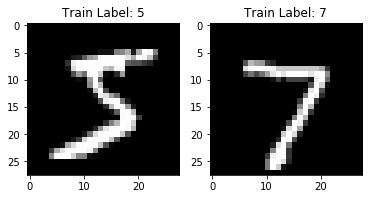

In [15]:
print(len(train_labels))
plt.figure(figsize=(6,3))

ax_x_train = plt.subplot(121)
ax_x_test = plt.subplot(122)

ax_x_train.set_title('Train Label: '+ str(train_labels[0]))
ax_x_train.imshow(train_examples[0],cmap='gray')
ax_x_test.set_title('Train Label: '+ str(test_labels[0]))
ax_x_test.imshow(test_examples[0],cmap='gray')

plt.show()

#### Load Numpy arrays with tf.data.Dataset
- <code>tf.data.Dataset.from_tensor_slices()</code>: dataset과 labels를 하나로 묶음과 동시에 Tensor로서 변환시킨다. Argument인 dataset과 label은 Tuple형식으로 전달한다.
- <code>train_dataset.shuffle()</code>: Dataset을 Shuffle한다. Argument로 주어지는 SUFFLE_BUFFER_SIZE는 Data의 개수보다 크거나 같은것이 좋다.
- <code>test_dataset.batch()</code>: Input으로 넣을 Tensor를 Batch_size에 맞게 조절한다.


In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

# Hyperparameter 선언
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

# Train Dataset Shuffle
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# Batch Size로서 변경
test_dataset = test_dataset.batch(BATCH_SIZE)

#### Model
위에서 준비한 Preprocessing Numpy Data로서 Model을 구성하고 결과를 확인한다.

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

model.fit(train_dataset, epochs=10)
model.evaluate(test_dataset)

Epoch 1/10
938/938 [==============================] - 2s 2ms/step - loss: 8.3879 - sparse_categorical_accuracy: 0.4766
Epoch 2/10
938/938 [==============================] - 2s 2ms/step - loss: 6.1293 - sparse_categorical_accuracy: 0.6166
Epoch 3/10
938/938 [==============================] - 2s 2ms/step - loss: 4.8214 - sparse_categorical_accuracy: 0.6980
Epoch 4/10
938/938 [==============================] - 2s 2ms/step - loss: 4.5923 - sparse_categorical_accuracy: 0.7128
Epoch 5/10
938/938 [==============================] - 2s 2ms/step - loss: 4.5060 - sparse_categorical_accuracy: 0.7184
Epoch 6/10
938/938 [==============================] - 2s 2ms/step - loss: 4.0114 - sparse_categorical_accuracy: 0.7490
Epoch 7/10
938/938 [==============================] - 2s 2ms/step - loss: 3.1366 - sparse_categorical_accuracy: 0.8029
Epoch 8/10
938/938 [==============================] - 2s 2ms/step - loss: 3.0169 - sparse_categorical_accuracy: 0.8107
Epoch 9/10
938/938 [============================

[2.8657501829657583, 0.8209]

### Load Pandas data
Code 참조: <a href="https://www.tensorflow.org/tutorials/load_data/pandas_dataframe?hl=ko">Tensorflow Core Load a pandas.DataFrame</a><br>
Pandas 참조: <a href="https://wjddyd66.github.io/dataanalysis/Pandas/">Pandas</a><br>

#### Setup
<code>tf.data.Dataset</code>중 CSV data를 Pandas를 사용하여 처리하는 방법에 대해서 알아보자.  
<code>tf.keras.utils.get_file()</code>를 활용하여 URL에서 CSV Format Dataset을 가져오자.  
<code>pd.read_csv()</code>를 CSV Format Dataset을 Pandas로 변환하여 결과를 확인하자.  
<code>df.head()</code>: 상위 5개 Data확인  
<code>df.dtypes</code>: Factor의 Type확인

In [18]:
# CSV File 가져오기
csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/applied-dl/heart.csv')
# CSV File을 Pandas로 변환
df = pd.read_csv(csv_file)
# 상위 5개 Data 확인
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [19]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal         object
target        int64
dtype: object

#### Pandas Data Preprocessing
위에서 각각의 Factor들의 Type을 확인해보면 **thal**이라는 Factor는 Numeric이 아니라 Object이다.  
따라서 Object -> Numeric으로서 Type을 변환시켜야 한다.  
<code>df.thal.cat.codes</code>를 통하여 Return Series of codes as well as the index즉, Index로서 변환시킨다.  
아래 결과를 살펴보게 되면  
Original Thal은 5개의 값으로서 이루워져 있다. (unique 5)  
이러한 값을 Index로서 치환하게 되어 thal Factor는 0 ~ 4사이의 값으로 치환되게 된다.

In [20]:
# Original thal Factor Check
print('Original Factor thal describe()')
print(df.thal.describe())

# Convert thal Factor Object to Numeric
df['thal'] = pd.Categorical(df['thal'])
df['thal'] = df.thal.cat.codes
print()
print('.cat.codes thal describe()')
print(df.thal.describe())
print()
print('-'*30)

# Check min, max of thal Factor
print('Min thal: ', min(df.thal))
print('Max thal: ', max(df.thal))

# 바뀐 DataFrame 확인
df.head()

Original Factor thal describe()
count        303
unique         5
top       normal
freq         168
Name: thal, dtype: object

.cat.codes thal describe()
count    303.000000
mean       3.303630
std        0.625258
min        0.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: thal, dtype: float64

------------------------------
Min thal:  0
Max thal:  4


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,2,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,4,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


#### Load data using tf.data.Dataset
<code>tf.data.Dataset.from_tensor_slices()</code>을 확용하여 InputData, Label로서 Dataset을 구성한다.

In [21]:
train_df = df[:int(len(df)*0.8)]
test_df = df[int(len(df)*0.8)+1:]

train_target = train_df.pop('target')
test_target = test_df.pop('target')

dataset = tf.data.Dataset.from_tensor_slices((train_df.values, train_target.values))
test = tf.data.Dataset.from_tensor_slices((test_df.values, test_target.values))

for feat, targ in dataset.take(5):
    print ('Features: {}, Target: {}'.format(feat, targ))

train_dataset = dataset.shuffle(len(train_df)).batch(1)
test_dataset = test.batch(1)

Features: [ 63.    1.    1.  145.  233.    1.    2.  150.    0.    2.3   3.    0.
   2. ], Target: 0
Features: [ 67.    1.    4.  160.  286.    0.    2.  108.    1.    1.5   2.    3.
   3. ], Target: 1
Features: [ 67.    1.    4.  120.  229.    0.    2.  129.    1.    2.6   2.    2.
   4. ], Target: 0
Features: [ 37.    1.    3.  130.  250.    0.    0.  187.    0.    3.5   3.    0.
   3. ], Target: 0
Features: [ 41.    0.    2.  130.  204.    0.    2.  172.    0.    1.4   1.    0.
   3. ], Target: 0


#### Model
위에서 준비한 Preprocessing Pandas Data로서 Model을 구성하고 결과를 확인한다.

In [22]:
def get_compiled_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = get_compiled_model()
model.fit(train_dataset, epochs=15)
model.evaluate(test_dataset)

Epoch 1/15
242/242 [==============================] - 1s 3ms/step - loss: 4.0793 - accuracy: 0.7762
Epoch 2/15
242/242 [==============================] - 0s 1ms/step - loss: 4.0793 - accuracy: 0.7762
Epoch 3/15
242/242 [==============================] - 0s 1ms/step - loss: 4.0793 - accuracy: 0.7762
Epoch 4/15
242/242 [==============================] - 0s 1ms/step - loss: 4.0793 - accuracy: 0.7762
Epoch 5/15
242/242 [==============================] - 0s 1ms/step - loss: 4.0793 - accuracy: 0.7762
Epoch 6/15
242/242 [==============================] - 0s 1ms/step - loss: 4.0793 - accuracy: 0.7762
Epoch 7/15
242/242 [==============================] - 0s 1ms/step - loss: 4.0793 - accuracy: 0.7762
Epoch 8/15
242/242 [==============================] - 0s 1ms/step - loss: 4.0793 - accuracy: 0.7762
Epoch 9/15
242/242 [==============================] - 0s 1ms/step - loss: 4.0793 - accuracy: 0.7762
Epoch 10/15
242/242 [==============================] - 0s 1ms/step - loss: 4.0793 - accuracy: 0.7762

[4.884567085901896, 0.68333334]